<a href="https://colab.research.google.com/github/Dohwan93/Image_Processing_Algorithms/blob/main/SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SAM2 https://github.com/facebookresearch/sam2

In [ ]:
!rm -rf sam2
!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -e .

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done


In [2]:
pip install -e ".[notebooks]"

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.5 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=b951da93e41ef5d4117a0f9062608075f96dbe9cf338c09b9a33f56322d9359b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsdmw175/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
Successfully built

In [3]:
!cd checkpoints && \
./download_ckpts.sh && \
!cd ..

--2025-12-09 06:06:49--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.129, 99.84.41.79, 99.84.41.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   274MB/s    in 0.5s    

2025-12-09 06:06:50 (274 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-12-09 06:06:50--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.129, 99.84.41.79, 99.84.41.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/

In [4]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

# Load the image using PIL and then pass the image object to set_image
image_path = "/content/cake.jpg"
image = Image.open(image_path).convert("RGB") # Ensure it's in RGB format

# Example point coordinates and labels for segmentation
# For 'Red strawberries on the cake', let's assume a point near a strawberry.
# These are example coordinates, you might need to adjust them based on the image.
# [X, Y] coordinates, and 1 for foreground, 0 for background.
point_coords = torch.tensor([[200, 200]], device=predictor.device)
point_labels = torch.tensor([1], device=predictor.device)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels
    )

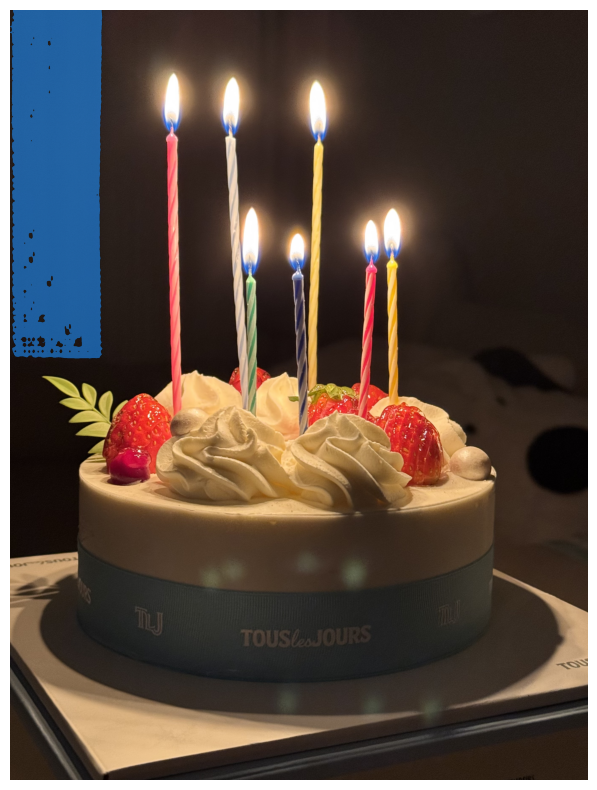

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # 파란색 계열, 투명도 0.6
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# 1. PIL 이미지를 numpy 배열로 변환하여 그리기
plt.figure(figsize=(10, 10))
plt.imshow(image)

# 2. 가장 높은 점수의 마스크 하나만 시각화 (인덱스 0번이 보통 점수가 가장 높음)
if masks.shape[0] > 0:
    show_mask(masks[0], plt.gca())

plt.axis('off')
plt.show()

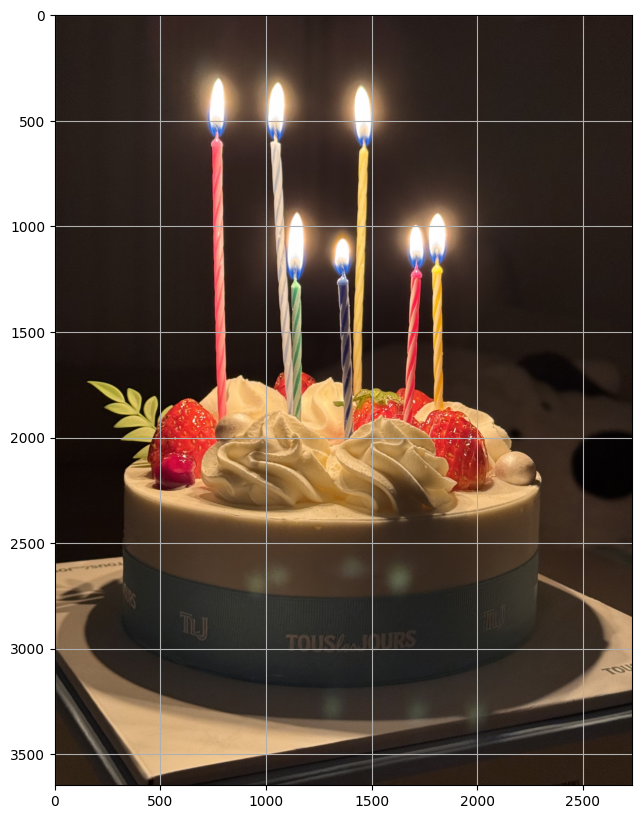

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.grid(True) # 그리드 켜기
plt.axis('on') # 축 눈금 켜기 (이미 켜져 있다면 생략 가능)
plt.show()

In [16]:
# 예: 촛불이 대략 (x:300~400, y:200~350) 영역에 있다면
box_coords = torch.tensor([[350, 1600, 2250, 2400]], device=predictor.device)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box_coords  # 박스 좌표 전달
    )

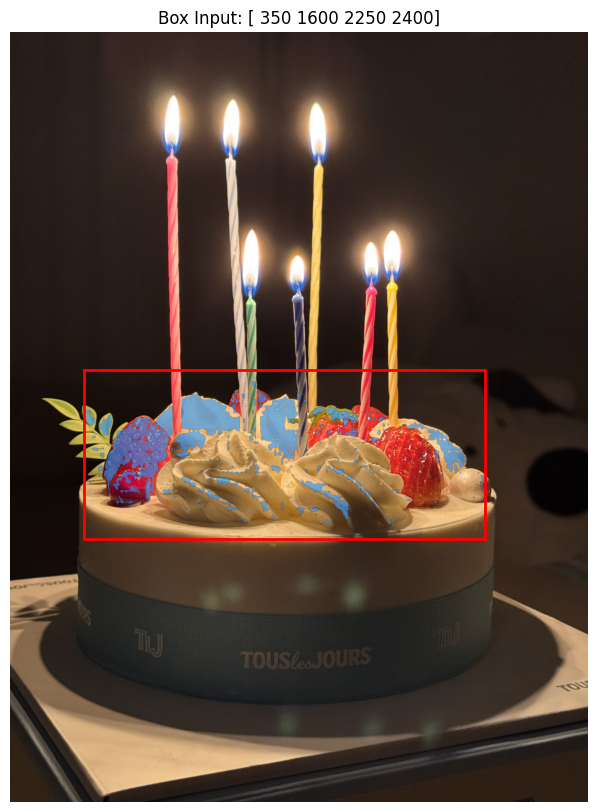

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- 시각화 함수 정의 ---
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # 파란색 마스크
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    # 박스를 빨간색 테두리로 그립니다
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor='none', lw=2))

# --- 결과 그리기 ---
plt.figure(figsize=(10, 10))
plt.imshow(image)

# 1. 생성된 마스크 그리기
if len(masks) > 0:
    show_mask(masks[0], plt.gca()) # 가장 점수가 높은 첫 번째 마스크 표시

# 2. 내가 입력한 박스 그리기 (좌표 확인용)
# box_coords는 tensor이므로 cpu().numpy()로 변환해야 합니다.
# 입력할 때 [ [x1, y1, x2, y2] ] 형태였으므로 첫 번째 박스를 가져옵니다.
input_box = box_coords[0].cpu().numpy()
show_box(input_box, plt.gca())

plt.title(f"Box Input: {input_box}")
plt.axis('off')
plt.show()

In [1]:
import torch
from sam2.build_sam import build_sam2_video_predictor

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    state = predictor.init_state("/content/IMG_0256.mp4")

    # add new prompts and instantly get the output on the same frame
    frame_idx, object_ids, masks = predictor.add_new_points_or_box(state, "car")

    # propagate the prompts to get masklets throughout the video
    for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
        ...

RuntimeError: You're likely running Python from the parent directory of the sam2 repository (i.e. the directory where https://github.com/facebookresearch/sam2 is cloned into). This is not supported since the `sam2` Python package could be shadowed by the repository name (the repository is also named `sam2` and contains the Python package in `sam2/sam2`). Please run Python from another directory (e.g. from the repo dir rather than its parent dir, or from your home directory) after installing SAM 2.